### The purpose of this notebook is to conduct time series forecasting and clustering
 - also making utility functions into a module
 

In [1]:
from basket_util import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
import collections

import plotly as py
import plotly.express as px
import plotly.offline as pyo
from plotly.offline import iplot, plot, init_notebook_mode, download_plotlyjs
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from pySankey.sankey import sankey

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import fpgrowth

import warnings
warnings.filterwarnings('ignore')


In [2]:
dropna = True
datecol = 'placed_at'
filename = 'new_baskets_full.csv'
#filename = 'new_baskets_adhie.csv'
#filename = 'offload_adhie_transaction_dataset_to_sep_22_forecasting_dataset_adhie_capstone_project.csv_as_is.csv'


baskets = prep_data(filename, dropna,datecol)
merchants = get_merchant_attributes(baskets)
sku_attributes = get_sku_attributes(baskets)
order_attributes = get_order_attributes(baskets)

sku_by_day = get_skus_by_day(baskets)
top_cats = make_top_cats(baskets)

In [3]:
baskets = baskets[baskets.merchant_id !=190]
baskets = baskets[baskets.merchant_id !=12]
baskets = baskets[baskets.merchant_id !=206]
baskets = baskets[baskets.date >=  pd.to_datetime('2021-09-27').date()]

df1 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='order_id', # Column to aggregate for values
    aggfunc="nunique")    # Aggregation function
df2 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='spent', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df1.fillna(0,inplace=True)
df2.fillna(0,inplace=True)

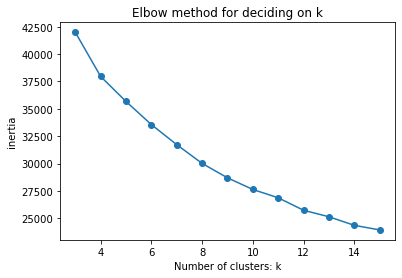

In [4]:
colnames = df1.columns
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df1, colnames,clusters_range)

In [5]:
colnames = df1.columns
k = 6
df1_kmeans = run_kmeans(df1, colnames,k)
df1_kmeans.groupby("cluster").size()

cluster
0    1682
1       1
2     310
3      17
4     102
5       3
dtype: int64

In [6]:
df1_results = df1_kmeans.groupby("cluster").mean().reset_index()

In [7]:
df1_results = df1_results.melt(id_vars="cluster")

<AxesSubplot:xlabel='top_cat_id', ylabel='value'>

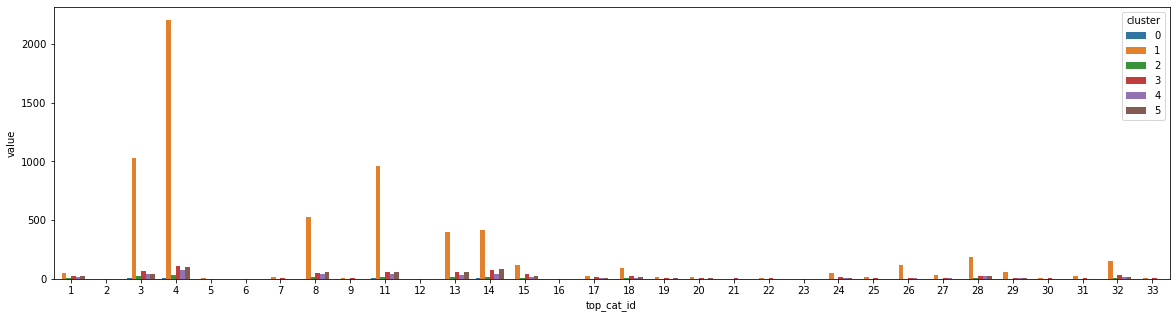

In [8]:
plt.figure(figsize=(20,5))
sns.barplot(data=df1_results,x="top_cat_id",y="value", hue = "cluster")

In [9]:
df1_results_pivot = pd.pivot_table(
    df1_results,
    index='top_cat_id',   # Column to turn into new index
    columns='cluster',  # Column to turn into new columns
    values='value', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df1_results_pivot

cluster,0,1,2,3,4,5
top_cat_id,,,,,,
1,1.285375,51.0,7.858065,24.294118,15.803922,23.666667
2,0.004756,0.0,0.019355,0.000000,0.049020,0.000000
3,4.489298,1031.0,22.609677,69.235294,44.656863,42.000000
4,7.969679,2204.0,36.406452,109.235294,77.764706,97.333333
5,0.074911,11.0,0.332258,0.058824,0.774510,0.333333
6,0.006540,0.0,0.022581,0.647059,0.049020,0.000000
7,0.094530,14.0,0.858065,6.882353,2.147059,2.333333
8,2.851962,525.0,15.345161,53.117647,38.000000,58.666667
9,0.082045,10.0,0.645161,4.000000,1.558824,1.000000


In [10]:
(df1_kmeans.query('cluster ==1'))

top_cat_id,1,2,3,4,5,6,7,8,9,11,...,25,26,27,28,29,30,31,32,33,cluster
merchant_id,,,,,,,,,,,,,,,,,,,,,
664,51.0,0.0,1031.0,2204.0,11.0,0.0,14.0,525.0,10.0,964.0,...,13.0,121.0,32.0,186.0,62.0,5.0,22.0,149.0,11.0,1


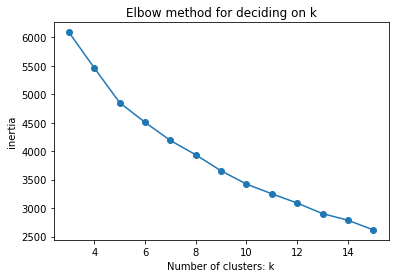

In [11]:
colnames = df2.columns
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(df2, colnames,clusters_range)

In [12]:
colnames = df2.columns
k = 8
df2_kmeans = run_kmeans(df2, colnames,k)
df2_kmeans.groupby("cluster").size()


cluster
0    219
1      1
2     82
3      3
4      1
5      1
6      2
7     16
dtype: int64

In [13]:
(df2.query('cluster ==0 or cluster==5'))

top_cat_id,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,cluster
merchant_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,592000.0,...,8339900.0,0.0,216000.0,0.0,0.0,171000.0,0.0,147000.0,0.0,0
2,90000.0,0.0,0.0,0.0,916000.0,0.0,0.0,0.0,0.0,365500.0,...,10004500.0,55000.0,245500.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,51000.0,0.0,1024000.0,0.0,0.0,215000.0,11500.0,1144500.0,...,27497700.0,0.0,349000.0,0.0,84000.0,20000.0,105000.0,592000.0,471000.0,0
4,0.0,0.0,0.0,65000.0,115000.0,0.0,0.0,0.0,0.0,603000.0,...,0.0,0.0,51000.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,255000.0,0.0,0.0,0.0,0.0,0.0,...,1779500.0,0.0,240000.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1755000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
326,0.0,0.0,51000.0,0.0,232000.0,0.0,0.0,0.0,0.0,173000.0,...,12110500.0,0.0,102000.0,0.0,0.0,0.0,0.0,0.0,58000.0,0
327,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,496000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [14]:
df2 = pd.pivot_table(
    baskets,
    index='merchant_id',   # Column to turn into new index
    columns='top_cat_id',  # Column to turn into new columns
    values='qty', # Column to aggregate for values
    aggfunc="sum")    # Aggregation function
df2.fillna(0,inplace=True)
df2.drop(labels=27, axis=1,  inplace=True, errors='raise')

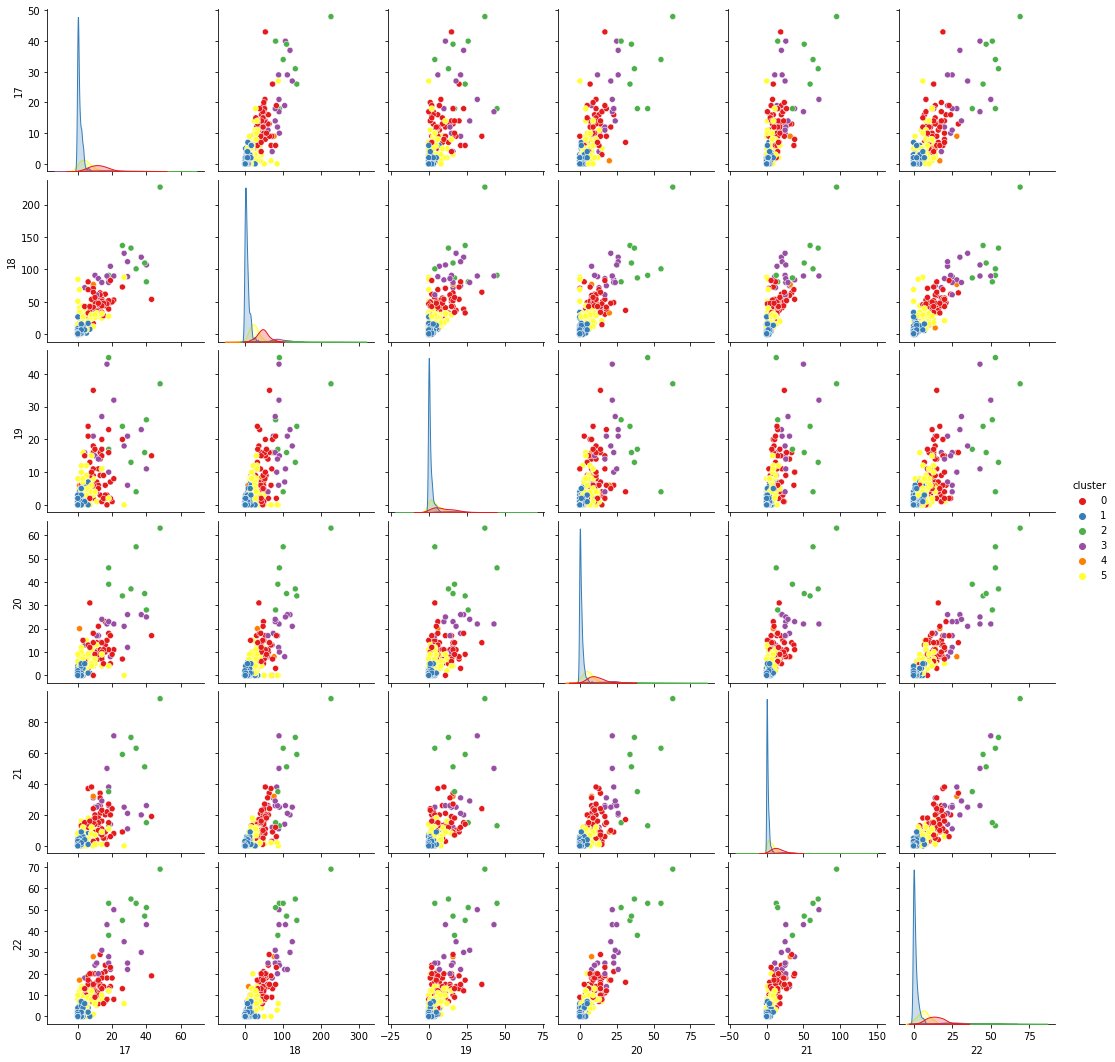

In [15]:
sns.pairplot(data=df1_kmeans[["cluster",17,18,19,20,21,22]], hue="cluster", palette="Set1")


 - this can be a good way to represent month and week for easy printing and use in axes for plotting

In [16]:
baskets.placed_at.apply(lambda t: t.strftime("%Y-%W"))

28813     2021-39
28814     2021-39
28815     2021-39
28816     2021-39
28817     2021-39
           ...   
392936    2022-39
392937    2022-39
392938    2022-39
392939    2022-39
392940    2022-39
Name: placed_at, Length: 262686, dtype: object

In [17]:
baskets[baskets.month1 == "2022-01"]

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month1,month_num,week_num,week1,day,hour,weekday,spent
118557,118583,11167,2022-01-02 08:46:08.894,113,1399,18,65,2,20000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,40000.0
118558,118584,11167,2022-01-02 08:46:08.894,113,964,27,86,3,70500.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,211500.0
118559,118585,11167,2022-01-02 08:46:08.894,113,976,27,86,2,165000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,330000.0
118560,118586,11167,2022-01-02 08:46:08.894,113,1171,27,84,1,168000.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,168000.0
118561,118587,11167,2022-01-02 08:46:08.894,113,711,34,100,5,10500.0,2022-01-02,2022,1,2022-01,13,52,2022-00,2,8,6,52500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150087,150095,14159,2022-01-31 17:05:15.920,125,866,27,86,1,163000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,163000.0
150088,150096,14159,2022-01-31 17:05:15.920,125,962,27,86,10,18700.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,187000.0
150089,150097,14159,2022-01-31 17:05:15.920,125,983,27,86,1,250000.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,250000.0
150090,150098,14159,2022-01-31 17:05:15.920,125,1488,27,86,1,240500.0,2022-01-31,2022,1,2022-01,13,57,2022-05,31,17,0,240500.0


In [18]:
df1_out = df1_kmeans.reset_index()
df1_unpivoted = df1_out.melt(id_vars = ['merchant_id'], var_name='top_cat_id', value_name='order_id')

In [19]:
df1_unpivoted

,merchant_id,top_cat_id,order_id
0,1,1,0.0
1,2,1,1.0
2,3,1,0.0
3,4,1,0.0
4,5,1,0.0
...,...,...,...
11695,325,cluster,1.0
11696,326,cluster,1.0
11697,327,cluster,1.0
11698,328,cluster,1.0


<AxesSubplot:xlabel='num_skus', ylabel='Density'>

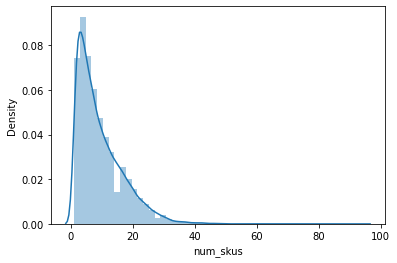

In [ ]:
sns.distplot(order_attributes.num_skus)


In [ ]:
(order_attributes.num_skus==1).sum()/order_attributes.shape[0]

0.04631923234169452

In [ ]:
((order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15) ).sum()/order_attributes.shape[0]

0.0024530434573483083

In [ ]:
order_attributes[(order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15)].head(100)

,order_id,total_spent,num_skus,num_top_cats,num_sub_cats
189,190,16100.0,1,1,1
430,431,17700.0,1,1,1
696,697,17800.0,1,1,1
723,724,17800.0,1,1,1
758,759,32000.0,1,1,1
...,...,...,...,...,...
39376,39379,16500.0,1,1,1
40129,40132,24000.0,1,1,1
40282,40285,47647000.0,14,5,3
40501,40504,32000.0,1,1,1


In [ ]:
order_attributes[(order_attributes.total_spent.apply(lambda x: math.log(x,2))>25) | \
(order_attributes.total_spent.apply(lambda x: math.log(x,2))<15)].head(100)

In [ ]:
392810/41581

9.446862749813617

In [ ]:
pd.set_option('display.max_rows', 100)
print(baskets.groupby("week_num").merchant_id.nunique())

In [ ]:
baskets[baskets["week_num"] < 39].groupby("merchant_id").nunique()

,id,order_id,placed_at,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month_num,week_num,day,hour,weekday,spent
merchant_id,,,,,,,,,,,,,,,,,
9,4,1,1,4,1,1,2,4,1,1,1,1,1,1,1,1,4
10,2,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,2
11,27494,3035,3035,634,33,80,64,542,93,1,4,4,15,31,11,7,1008
12,310,15,15,122,22,36,37,133,10,1,2,2,4,10,4,6,183
13,2,2,2,1,1,1,1,2,1,1,1,1,1,1,1,1,2
14,99,8,8,69,13,22,21,73,8,1,2,2,4,8,2,6,74
15,61,4,4,56,11,19,19,55,4,1,2,2,4,4,2,3,55
16,2,1,1,2,1,1,1,2,1,1,1,1,1,1,1,1,2
17,9,1,1,9,2,2,1,9,1,1,1,1,1,1,1,1,9


for weekly analysis, to make the work meaningful, we should use data from week 39 and onwards
for monthly analysis, to make the work meaningful, we should use the data from month October 2021 to Sepetember 2022.

In [ ]:
sku_attributes.groupby("tenure_month").count()

,sku_id,total_spent,num_orders,num_merchants,first_month,last_month,num_months,num_weeks,num_days,avg_spent_per_order
tenure_month,,,,,,,,,,
1,55,55,55,55,55,55,55,55,55,55
2,55,55,55,55,55,55,55,55,55,55
3,51,51,51,51,51,51,51,51,51,51
4,172,172,172,172,172,172,172,172,172,172
5,416,416,416,416,416,416,416,416,416,416
6,19,19,19,19,19,19,19,19,19,19
7,27,27,27,27,27,27,27,27,27,27
8,27,27,27,27,27,27,27,27,27,27
9,36,36,36,36,36,36,36,36,36,36


In [ ]:
sku_attributes.shape

(1800, 13)

In [ ]:
print(sku_attributes.groupby("first_week").sku_id.nunique())

In [ ]:
fig = px.parallel_coordinates(merchants[["first_month","merchant_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"merchant_id": "merchant ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

<Figure size 6000x3000 with 0 Axes>

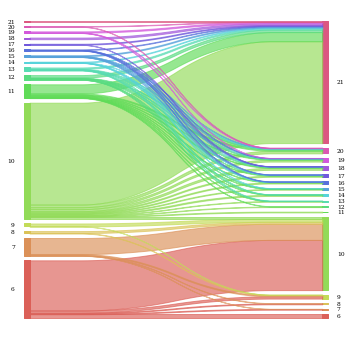

In [ ]:
plt.figure(figsize=(30, 15), dpi=200)
df = sku_attributes.groupby(["first_month","last_month"]).sku_id.nunique().reset_index()
sankey(
    left=df["first_month"], right=df["last_month"],
    leftWeight= df["sku_id"], rightWeight=df["sku_id"], 
    aspect=20, fontsize=6
)

In [ ]:
fig = px.parallel_coordinates(merchants[["first_month","merchant_id","last_month","tenure_month"]], \
        color="tenure_month", labels={"merchant_id": "merchant ID",
                "first_month": "First Month", "last_month": "Last Month", },)
                             #color_continuous_scale=px.colors.diverging.Tealrose,
                            # color_continuous_midpoint=2)
fig.show()

In [ ]:
merchants[merchants.merchant_id==11]

,merchant_id,total_spent,num_orders,first_month,last_month,num_months,num_weeks,num_days,num_skus,num_top_cats,num_sub_cats,avg_spent_per_order,tenure_month
10,11,3.553156e+09,3236,6,20,7,21,117,663,33,81,1.098009e+06,15


In [ ]:
(baskets.query('merchant_id ==11').query('month_num == 20'))


,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month_num,week_num,day,hour,weekday,spent
350144,350165,36455,2022-08-22 13:44:40.652,11,1133,16,50,1,55000.0,2022-08-22,2022,8,20,86,22,13,0,55000.0
350145,350166,36455,2022-08-22 13:44:40.652,11,920,16,86,1,59500.0,2022-08-22,2022,8,20,86,22,13,0,59500.0


In [ ]:
1133 => 967056
920 ==>966689

<Figure size 6000x3000 with 0 Axes>

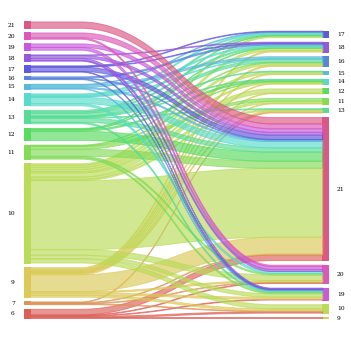

In [ ]:
plt.figure(figsize=(30, 15), dpi=200)
df = merchants.groupby(["first_month","last_month"]).merchant_id.nunique().reset_index()
sankey(
    left=df["first_month"], right=df["last_month"],
    leftWeight= df["merchant_id"], rightWeight=df["merchant_id"], 
    aspect=20, fontsize=6
)

<AxesSubplot:>

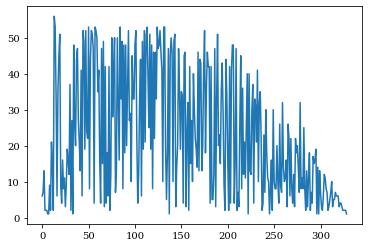

In [ ]:
merchants.num_weeks.plot()

In [ ]:
def count_unique(s):
    return len(s.unique())

sku_frequency = (baskets
    .groupby('sku_id')
    ['order_id']
 .agg(count_unique) # aggregate using the custom count_unique function
 .reset_index()
)


In [ ]:
sku_frequency.head()
px.line(sku_attributes.num_orders)

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [ ]:
sum(sku_frequency.order_id>50)

892

In [ ]:
px.line(sku_frequency.sort_values("order_id", ascending = False).reset_index().order_id)


/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/yingli/opt/anaconda3/lib/python3.9/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [ ]:
px.line(sku_frequency, x='',y='order_id',width=800,height=300)

TypeError: 'module' object is not callable

In [ ]:
sku_frequency.sort_values("order_id",ascending=False)

,sku_id,order_id
1487,1488,11847
858,859,8948
1496,1497,8267
865,866,7672
975,976,7466
...,...,...
914,915,3
1730,1731,3
664,665,3
0,1,3


<AxesSubplot:>

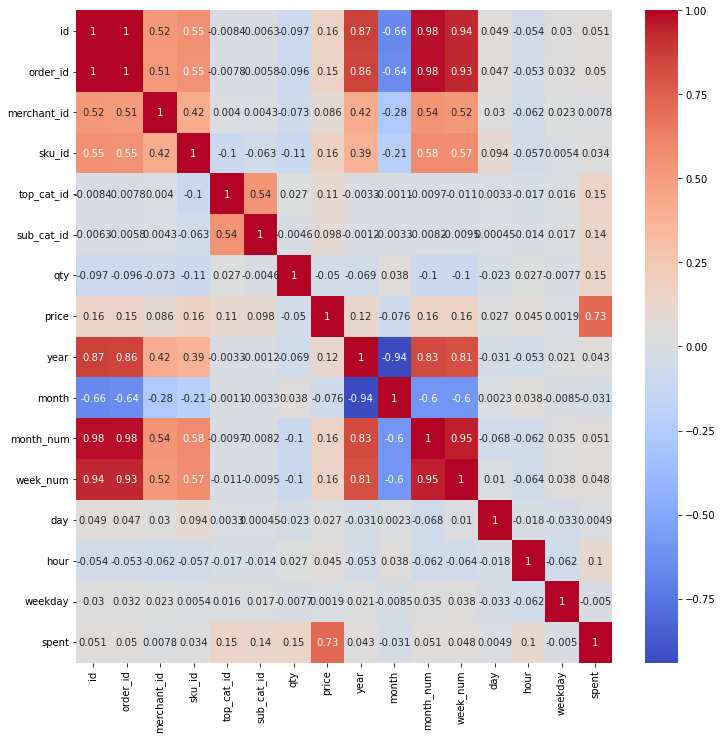

In [ ]:
plt.figure(figsize=(12,12)) 
sns.heatmap(baskets.corr(),annot=True, cmap='coolwarm')

In [ ]:
px.line(pd.crosstab(baskets['week_num'], baskets['top_cat_id']),width=800,height=800)

In [ ]:
df = baskets
df.groupby('order_id').all()

,id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,date,year,month,month_num,week_num,day,hour,weekday,spent
order_id,,,,,,,,,,,,,,,,,
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22804,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
22805,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
22806,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [ ]:
transaction_data = []
for groups in df.groupby('order_id').groups.values():
    transaction_data.append(list(df.loc[groups]['sku_id'].to_numpy()))

In [ ]:
transaction_data[0]

[470,
 237,
 236,
 238,
 547,
 253,
 355,
 1354,
 281,
 425,
 204,
 1367,
 570,
 276,
 269,
 271,
 569,
 493,
 404,
 235,
 1558,
 1300,
 299,
 438,
 589,
 435,
 432,
 1545,
 460,
 1544,
 481,
 485,
 762,
 327,
 267,
 336,
 184,
 337,
 710,
 717,
 501,
 1577,
 1335,
 262]

In [ ]:
def oneHotCoding(transaction_data):
    te = TransactionEncoder()
    te_ary = te.fit(transaction_data).transform(transaction_data)
    transaction_df = pd.DataFrame(te_ary, columns=te.columns_)
    return transaction_df

transaction_sku_data = oneHotCoding(transaction_data)

In [ ]:
transaction_sku_data[1]

0        False
1        False
2        False
3        False
4        False
         ...  
62042    False
62043    False
62044    False
62045    False
62046    False
Name: 1, Length: 62047, dtype: bool

In [ ]:
def frq_sku_itemsets(data,suppVar):
    min_support = suppVar/data.shape[0]
    frequent_itemsets = fpgrowth(data, min_support=min_support, use_colnames=True)
    return frequent_itemsets

freq_itemsets = frq_sku_itemsets(transaction_sku_data,30)

In [ ]:
freq_itemsets.head(50)

,support,itemsets
0,0.120860,(327)
1,0.090077,(438)
2,0.059906,(276)
3,0.056054,(184)
4,0.055313,(432)
5,0.052476,(485)
6,0.051590,(336)
7,0.049463,(547)
8,0.042307,(337)
9,0.041549,(1300)


In [ ]:
# compute and print the association rules

def basket_rules(freq_itemsets,metrics,threshold):
    asso_rules = association_rules(freq_itemsets, metric=metrics, min_threshold=threshold)
    return asso_rules.sort_values(by='lift', ascending=False)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

fp_rules = basket_rules(freq_itemsets,"confidence",0.10)
fp_rules.head(60)

,antecedents,consequents,support,confidence,lift
884882,(1245),(1244),0.000564,0.564516,875.663306
884881,(1244),(1245),0.000564,0.875000,875.663306
872749,"(432, 858)","(859, 435)",0.000484,0.491803,726.545667
872746,"(859, 435)","(432, 858)",0.000484,0.714286,726.545667
872747,"(432, 859)","(858, 435)",0.000484,0.454545,705.079545
872748,"(858, 435)","(432, 859)",0.000484,0.750000,705.079545
884369,"(1105, 1107)",(1106),0.000548,0.944444,681.394703
884372,(1106),"(1105, 1107)",0.000548,0.395349,681.394703
881905,"(977, 978)","(976, 975)",0.000548,0.723404,669.926326
881904,"(976, 975)","(977, 978)",0.000548,0.507463,669.926326


In [ ]:
fp_rules

,antecedents,consequents,support,confidence,lift
884882,(1245),(1244),0.000564,0.564516,875.663306
884881,(1244),(1245),0.000564,0.875000,875.663306
872749,"(432, 858)","(859, 435)",0.000484,0.491803,726.545667
872746,"(859, 435)","(432, 858)",0.000484,0.714286,726.545667
872747,"(432, 859)","(858, 435)",0.000484,0.454545,705.079545
...,...,...,...,...,...
683866,(283),(327),0.000967,0.111524,0.922755
683868,"(282, 283)",(327),0.000532,0.104762,0.866804
866618,(626),(327),0.000580,0.104651,0.865888
793910,"(419, 420)",(327),0.001451,0.103093,0.852993


In [ ]:
def predict(antecedent, rules, max_results= 6):
    
    # get the rules for this antecedent
    preds = rules[rules['antecedents'] == antecedent]
    
    # a way to convert a frozen set with one element to string
    preds = preds['consequents'].apply(iter).apply(next)
    
    return preds[:max_results]

In [ ]:
preds = predict({859, 435}, fp_rules)
preds

872746    432
872739    858
872384    432
Name: consequents, dtype: int64

In [ ]:
fp_rules.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 885767 entries, 884882 to 793902
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   antecedents  885767 non-null  object 
 1   consequents  885767 non-null  object 
 2   support      885767 non-null  float64
 3   confidence   885767 non-null  float64
 4   lift         885767 non-null  float64
dtypes: float64(3), object(2)
memory usage: 40.5+ MB
